# Secuenciacion de ADN y prediccion del tipo de gen

En este cuaderno se construye un pipeline de IA para predecir el tipo de gen (`GeneType`)
a partir de secuencias de ADN. Se usa un dataset de genes humanos anotados y modelos de
aprendizaje automatico basados en TF-IDF de 3-gramas de caracteres y regresion logistica.


## Indice

- Introduccion biologica: estructura de una secuencia de ADN
- Importacion de librerias y configuracion
- Carga de datos
- Exploracion de datos (EDA)
- Preprocesamiento de etiquetas y representacion TF-IDF
- Definicion del pipeline y funcion de entrenamiento
- Entrenamiento de modelos:
  - Modelo 1: multiclase completo (GeneType)
  - Modelo 2: PSEUDO vs OTHERS
  - Modelo 3: PSEUDO + BIOLOGICAL_REGION vs OTHERS
  - Modelo 4: PSEUDO + BIOLOGICAL_REGION + ncRNA vs OTHERS
- Comparacion de modelos (grafico de barras de accuracy)
- Guardado de modelos entrenados
- Funciones de prediccion para nuevas secuencias
- Conclusiones y trabajo futuro


## Estructura biologica de una secuencia de ADN y relacion con el modelo

Una secuencia genetica de ADN se puede ver a varios niveles:

1. **Nucleotidos**: son las unidades basicas (A, C, G, T).
2. **Pares de bases**: A se aparea con T, C con G.
3. **Codones**: grupos de 3 nucleotidos consecutivos. Cada triplete codifica un aminoacido
   o una senal de parada (STOP). Por ejemplo: ATG, TGC, GAA.
4. **Regiones codificantes (exones)**: fragmentos que si codifican proteinas.
5. **Regiones no codificantes (intrones)**: fragmentos que no se traducen a proteina.
6. **Regiones reguladoras**: promotores, potenciadores, UTR, etc., que controlan cuando
   y como se expresa un gen.
7. **Genes funcionales vs pseudogenes**: los genes funcionales mantienen un marco de
   lectura coherente (inicio, codones internos, STOP). Los pseudogenes suelen presentar
   mutaciones, cortes o patrones alterados.

En este proyecto el modelo usa TF-IDF de **ngrama de tamanio 3 a nivel de caracteres**.
Es decir, trabaja exactamente con codones (tripletes). Esto permite capturar patrones
biologicos reales de exones, intrones, regiones reguladoras y pseudogenes en la secuencia
de ADN, lo que justifica el diseno del modelo.


In [51]:
# Suprimir advertencias para que la salida sea mas limpia
import warnings
warnings.filterwarnings("ignore")

# Librerias basicas
import numpy as np
import pandas as pd

# Configuracion de matplotlib (backend sin interfaz grafica)
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

# Esta linea es util en Jupyter Notebooks
%matplotlib inline

# Libreria para graficos estadisticos
import seaborn as sns

# Librerias de scikit-learn para construir y evaluar modelos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Libreria para guardar y cargar modelos entrenados
import joblib

# Estilo por defecto de los graficos de Seaborn
sns.set(style="whitegrid")

## Carga de datos

En esta seccion se cargan los archivos `train.csv`, `validation.csv` y `test.csv`
desde la carpeta `dna-sequence-prediction/`. Se revisan sus dimensiones y se elimna
una columna de indice que no aporta informacion.


In [52]:
# Cargar los conjuntos de datos desde el directorio relativo
train_df = pd.read_csv("dna-sequence-prediction/train.csv", encoding="ascii")
val_df   = pd.read_csv("dna-sequence-prediction/validation.csv", encoding="ascii")
test_df  = pd.read_csv("dna-sequence-prediction/test.csv", encoding="ascii")

# Mostrar las dimensiones de los conjuntos de datos
print("Forma de datos de entrenamiento:", train_df.shape)
print("Forma de datos de validacion:", val_df.shape)
print("Forma de datos de prueba:", test_df.shape)

# Mostrar algunas filas para ver la estructura
print("\nPrimeras filas del conjunto de entrenamiento:")
print(train_df.head())

print("\nInformacion de columnas del conjunto de entrenamiento:")
print(train_df.info())

Forma de datos de entrenamiento: (22593, 7)
Forma de datos de validacion: (4577, 7)
Forma de datos de prueba: (8326, 7)

Primeras filas del conjunto de entrenamiento:
   Unnamed: 0  NCBIGeneID        Symbol  \
0           0   106481178      RNU4-21P   
1           1   123477792  LOC123477792   
2           2   113174975  LOC113174975   
3           3   116216107  LOC116216107   
4           4       28502      IGHD2-21   

                                         Description           GeneType  \
0               RNA, U4 small nuclear 21, pseudogene             PSEUDO   
1                Sharpr-MPRA regulatory region 12926  BIOLOGICAL_REGION   
2                 Sharpr-MPRA regulatory region 7591  BIOLOGICAL_REGION   
3  CRISPRi-validated cis-regulatory element chr10...  BIOLOGICAL_REGION   
4                immunoglobulin heavy diversity 2-21              OTHER   

  GeneGroupMethod                                 NucleotideSequence  
0   NCBI Ortholog  <AGCTTAGCACAGTGGCAGTATCATAGGCAGTG

In [53]:
# Eliminar la columna 'Unnamed: 0' si existe en los dataframes
for df in [train_df, val_df, test_df]:
    if "Unnamed: 0" in df.columns:
        df.drop("Unnamed: 0", axis=1, inplace=True)

# Verificar valores faltantes en el conjunto de entrenamiento
print("Valores faltantes en los datos de entrenamiento:")
print(train_df.isnull().sum())

Valores faltantes en los datos de entrenamiento:
NCBIGeneID            0
Symbol                0
Description           0
GeneType              0
GeneGroupMethod       0
NucleotideSequence    0
dtype: int64


## Exploracion de datos (EDA)

En esta parte se analiza:

- La distribucion de la variable objetivo `GeneType`.
- La longitud de las secuencias de nucleotidos (`NucleotideSequence`).

Esto permite entender el desbalance de clases y la variabilidad de las secuencias.

Distribucion de GeneType en los datos de entrenamiento:
GeneType
PSEUDO               10220
BIOLOGICAL_REGION     6925
ncRNA                 2497
snoRNA                1148
PROTEIN_CODING         524
tRNA                   488
OTHER                  366
rRNA                   277
snRNA                  145
scRNA                    3
Name: count, dtype: int64


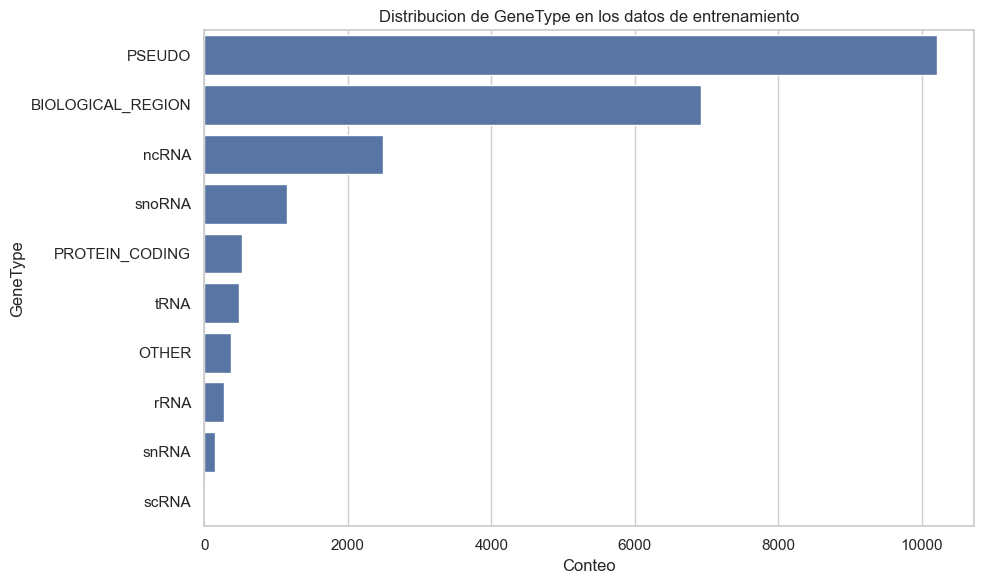

In [54]:
# Distribucion de la variable objetivo GeneType
gene_type_counts = train_df["GeneType"].value_counts()
print("Distribucion de GeneType en los datos de entrenamiento:")
print(gene_type_counts)

# Grafico de barras de la distribucion de GeneType
plt.figure(figsize=(10, 6))
sns.countplot(y="GeneType",
              data=train_df,
              order=gene_type_counts.index)
plt.title("Distribucion de GeneType en los datos de entrenamiento")
plt.xlabel("Conteo")
plt.ylabel("GeneType")
plt.tight_layout()
plt.show()


Resumen de la longitud de las secuencias:
count    22593.000000
mean       361.724871
std        260.474730
min          4.000000
25%        122.000000
50%        297.000000
75%        520.000000
max       1002.000000
Name: seq_length, dtype: float64


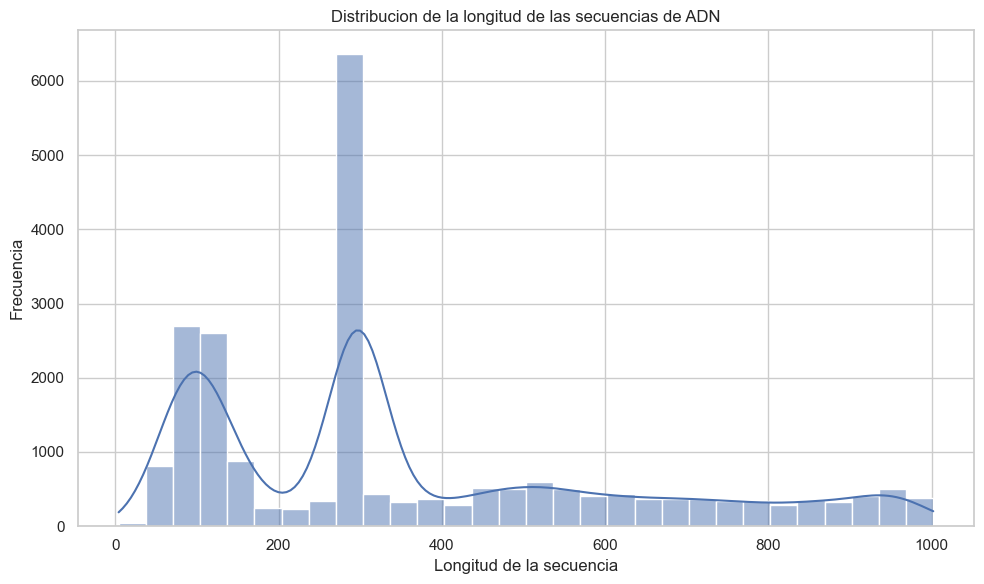

In [55]:
# Crear una nueva columna con la longitud de la secuencia de nucleotidos
train_df["seq_length"] = train_df["NucleotideSequence"].str.len()

print("Resumen de la longitud de las secuencias:")
print(train_df["seq_length"].describe())

# Histograma de longitudes de secuencia
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x="seq_length", kde=True, bins=30)
plt.title("Distribucion de la longitud de las secuencias de ADN")
plt.xlabel("Longitud de la secuencia")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


## Preprocesamiento de etiquetas

El dataset original trae muchas clases en `GeneType`. Para estudiar distintos
escenarios de clasificacion se definen nuevas etiquetas:

- Modelo 1: usa `GeneType` tal como viene (multiclase completo).
- Modelo 2: `PSEUDO` vs `OTHERS`.
- Modelo 3: `PSEUDO` o `BIOLOGICAL_REGION` vs `OTHERS`.
- Modelo 4: `PSEUDO`, `BIOLOGICAL_REGION`, `ncRNA` vs `OTHERS`.

Esto permite comparar que tan bien funciona el modelo cuando se simplifica la
estructura de clases.


In [56]:
# Copia de seguridad opcional
base_train_df = train_df.copy()
base_val_df   = val_df.copy()
base_test_df  = test_df.copy()

# Etiquetas para modelo 2: PSEUDO vs OTHERS
train_df["Label_pseudo_vs_others"] = train_df["GeneType"].apply(
    lambda x: "PSEUDO" if x == "PSEUDO" else "OTHERS"
)
val_df["Label_pseudo_vs_others"] = val_df["GeneType"].apply(
    lambda x: "PSEUDO" if x == "PSEUDO" else "OTHERS"
)
test_df["Label_pseudo_vs_others"] = test_df["GeneType"].apply(
    lambda x: "PSEUDO" if x == "PSEUDO" else "OTHERS"
)

# Etiquetas para modelo 3: PSEUDO o BIOLOGICAL_REGION vs OTHERS
train_df["Label_pseudo_bioregion_vs_others"] = train_df["GeneType"].apply(
    lambda x: x if x in ["PSEUDO", "BIOLOGICAL_REGION"] else "OTHERS"
)
val_df["Label_pseudo_bioregion_vs_others"] = val_df["GeneType"].apply(
    lambda x: x if x in ["PSEUDO", "BIOLOGICAL_REGION"] else "OTHERS"
)
test_df["Label_pseudo_bioregion_vs_others"] = test_df["GeneType"].apply(
    lambda x: x if x in ["PSEUDO", "BIOLOGICAL_REGION"] else "OTHERS"
)

# Etiquetas para modelo 4: PSEUDO, BIOLOGICAL_REGION, ncRNA vs OTHERS
train_df["Label_pseudo_bioregion_ncrna_vs_others"] = train_df["GeneType"].apply(
    lambda x: x if x in ["PSEUDO", "BIOLOGICAL_REGION", "ncRNA"] else "OTHERS"
)
val_df["Label_pseudo_bioregion_ncrna_vs_others"] = val_df["GeneType"].apply(
    lambda x: x if x in ["PSEUDO", "BIOLOGICAL_REGION", "ncRNA"] else "OTHERS"
)
test_df["Label_pseudo_bioregion_ncrna_vs_others"] = test_df["GeneType"].apply(
    lambda x: x if x in ["PSEUDO", "BIOLOGICAL_REGION", "ncRNA"] else "OTHERS"
)

print("Distribucion de etiquetas para modelo 2 (train):")
print(train_df["Label_pseudo_vs_others"].value_counts())

print("\nDistribucion de etiquetas para modelo 3 (train):")
print(train_df["Label_pseudo_bioregion_vs_others"].value_counts())

print("\nDistribucion de etiquetas para modelo 4 (train):")
print(train_df["Label_pseudo_bioregion_ncrna_vs_others"].value_counts())

Distribucion de etiquetas para modelo 2 (train):
Label_pseudo_vs_others
OTHERS    12373
PSEUDO    10220
Name: count, dtype: int64

Distribucion de etiquetas para modelo 3 (train):
Label_pseudo_bioregion_vs_others
PSEUDO               10220
BIOLOGICAL_REGION     6925
OTHERS                5448
Name: count, dtype: int64

Distribucion de etiquetas para modelo 4 (train):
Label_pseudo_bioregion_ncrna_vs_others
PSEUDO               10220
BIOLOGICAL_REGION     6925
OTHERS                2951
ncRNA                 2497
Name: count, dtype: int64


## Definicion del pipeline y funcion de entrenamiento

Se define un pipeline que aplica:

1. `TfidfVectorizer(analyzer="char", ngram_range=(3,3))`  
   - convierte las secuencias de ADN en vectores numericos basados en codones (3-gramas).
2. `LogisticRegression`  
   - clasificador lineal que aprende a separar las clases en el espacio de caracteristicas.

Tambien se implementa una funcion generica para entrenar y evaluar modelos con distintas etiquetas.


In [57]:
def build_pipeline(class_weight=None):
    """
    Construye un pipeline de TF-IDF (3-gramas de caracteres) + regresion logistica.
    El parametro class_weight permite manejar desbalance de clases.
    """
    clf = LogisticRegression(max_iter=1000, class_weight=class_weight)
    pipe = make_pipeline(
        TfidfVectorizer(analyzer="char", ngram_range=(3, 3)),
        clf
    )
    return pipe


def train_and_evaluate_model(name, train_df, val_df, label_col, class_weight=None):
    """
    Entrena un modelo sobre train_df usando la columna de etiquetas label_col
    y evalua su rendimiento sobre val_df. Devuelve el modelo entrenado y la accuracy.
    """
    # Entradas (X) y salidas (y)
    X_train = train_df["NucleotideSequence"]
    y_train = train_df[label_col]
    X_val   = val_df["NucleotideSequence"]
    y_val   = val_df[label_col]

    # Construir pipeline y entrenar
    model = build_pipeline(class_weight=class_weight)
    model.fit(X_train, y_train)

    # Predicciones en validacion
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    print("\n==============================")
    print(f"Modelo: {name}")
    print(f"Accuracy en validacion: {acc:.4f}")

    print("\nReporte de clasificacion:")
    print(classification_report(y_val, y_pred))

    # Matriz de confusion
    classes = model.named_steps["logisticregression"].classes_
    cm = confusion_matrix(y_val, y_pred, labels=classes)

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"Matriz de confusion - {name}")
    plt.xlabel("Etiqueta predicha")
    plt.ylabel("Etiqueta verdadera")
    plt.tight_layout()
    plt.show()

    return model, acc


## Entrenamiento de modelos

A continuacion se entrenan cuatro modelos con la misma arquitectura (TF-IDF + regresion logistica)
pero con distintas definiciones de etiqueta:

- Modelo 1: multiclase original (`GeneType`).
- Modelo 2: `PSEUDO` vs `OTHERS`.
- Modelo 3: (`PSEUDO`, `BIOLOGICAL_REGION`) vs `OTHERS`.
- Modelo 4: (`PSEUDO`, `BIOLOGICAL_REGION`, `ncRNA`) vs `OTHERS`.



Modelo: Modelo 1 - GeneType multiclase
Accuracy en validacion: 0.7070

Reporte de clasificacion:
                   precision    recall  f1-score   support

BIOLOGICAL_REGION       0.67      0.71      0.69      1398
            OTHER       0.67      0.14      0.23        88
   PROTEIN_CODING       0.33      0.01      0.02       101
           PSEUDO       0.73      0.84      0.78      2133
            ncRNA       0.67      0.42      0.52       516
             rRNA       0.75      0.75      0.75         8
            snRNA       0.67      0.18      0.29        22
           snoRNA       0.77      0.56      0.65       239
             tRNA       0.91      0.93      0.92        72

         accuracy                           0.71      4577
        macro avg       0.68      0.50      0.54      4577
     weighted avg       0.70      0.71      0.69      4577



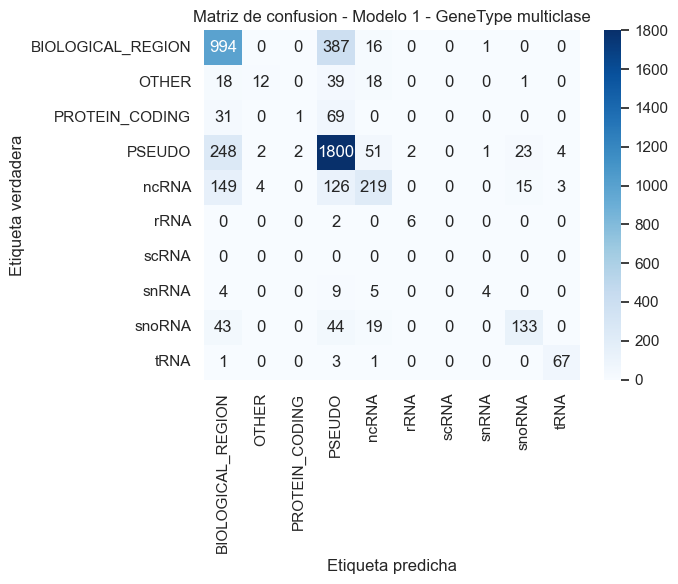


Modelo: Modelo 2 - PSEUDO vs OTHERS
Accuracy en validacion: 0.7719

Reporte de clasificacion:
              precision    recall  f1-score   support

      OTHERS       0.78      0.79      0.79      2444
      PSEUDO       0.76      0.75      0.75      2133

    accuracy                           0.77      4577
   macro avg       0.77      0.77      0.77      4577
weighted avg       0.77      0.77      0.77      4577



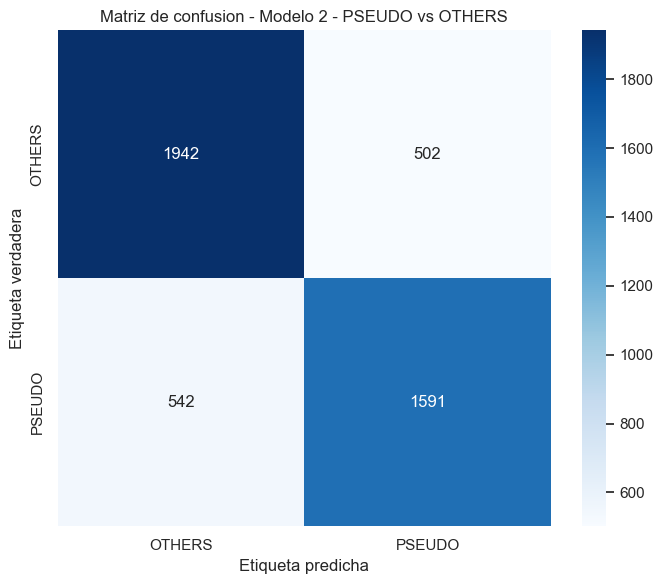


Modelo: Modelo 3 - PSEUDO o BIOLOGICAL_REGION vs OTHERS
Accuracy en validacion: 0.7090

Reporte de clasificacion:
                   precision    recall  f1-score   support

BIOLOGICAL_REGION       0.65      0.73      0.69      1398
           OTHERS       0.65      0.63      0.64      1046
           PSEUDO       0.78      0.73      0.76      2133

         accuracy                           0.71      4577
        macro avg       0.70      0.70      0.70      4577
     weighted avg       0.71      0.71      0.71      4577



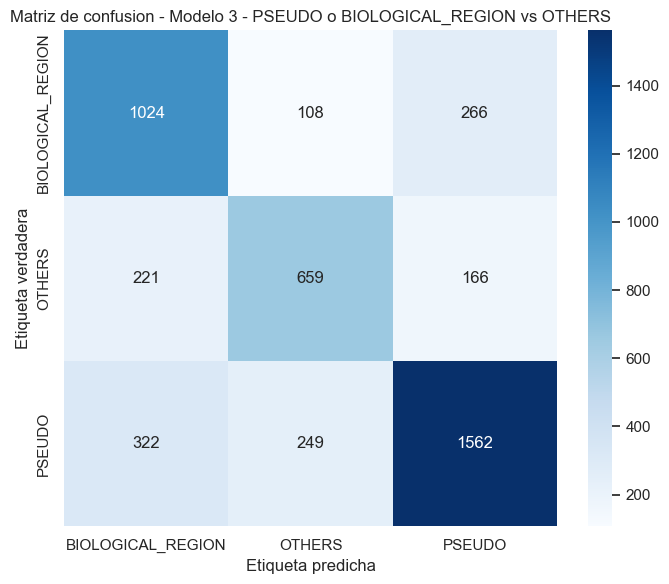


Modelo: Modelo 4 - PSEUDO, BIOLOGICAL_REGION, ncRNA vs OTHERS
Accuracy en validacion: 0.6675

Reporte de clasificacion:
                   precision    recall  f1-score   support

BIOLOGICAL_REGION       0.67      0.69      0.68      1398
           OTHERS       0.47      0.51      0.49       530
           PSEUDO       0.79      0.71      0.75      2133
            ncRNA       0.48      0.57      0.52       516

         accuracy                           0.67      4577
        macro avg       0.60      0.62      0.61      4577
     weighted avg       0.68      0.67      0.67      4577



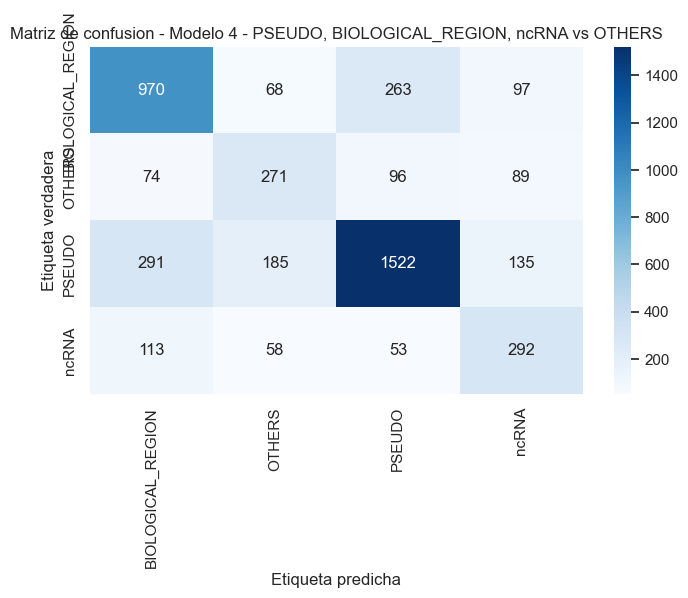

In [58]:
# Modelo 1: multiclase completo
model_1, acc_1 = train_and_evaluate_model(
    name="Modelo 1 - GeneType multiclase",
    train_df=train_df,
    val_df=val_df,
    label_col="GeneType",
    class_weight=None
)

# Modelo 2: PSEUDO vs OTHERS
model_2, acc_2 = train_and_evaluate_model(
    name="Modelo 2 - PSEUDO vs OTHERS",
    train_df=train_df,
    val_df=val_df,
    label_col="Label_pseudo_vs_others",
    class_weight=None
)

# Modelo 3: PSEUDO o BIOLOGICAL_REGION vs OTHERS (con class_weight balanceado)
model_3, acc_3 = train_and_evaluate_model(
    name="Modelo 3 - PSEUDO o BIOLOGICAL_REGION vs OTHERS",
    train_df=train_df,
    val_df=val_df,
    label_col="Label_pseudo_bioregion_vs_others",
    class_weight="balanced"
)

# Modelo 4: PSEUDO, BIOLOGICAL_REGION, ncRNA vs OTHERS (class_weight balanceado)
model_4, acc_4 = train_and_evaluate_model(
    name="Modelo 4 - PSEUDO, BIOLOGICAL_REGION, ncRNA vs OTHERS",
    train_df=train_df,
    val_df=val_df,
    label_col="Label_pseudo_bioregion_ncrna_vs_others",
    class_weight="balanced"
)


## Comparacion de modelos (accuracy en validacion)

En esta seccion se comparan las precisiones (accuracy) de los cuatro modelos
en un mismo grafico de barras. Esto permite ver cual configuracion de etiquetas
funciona mejor con la arquitectura elegida.


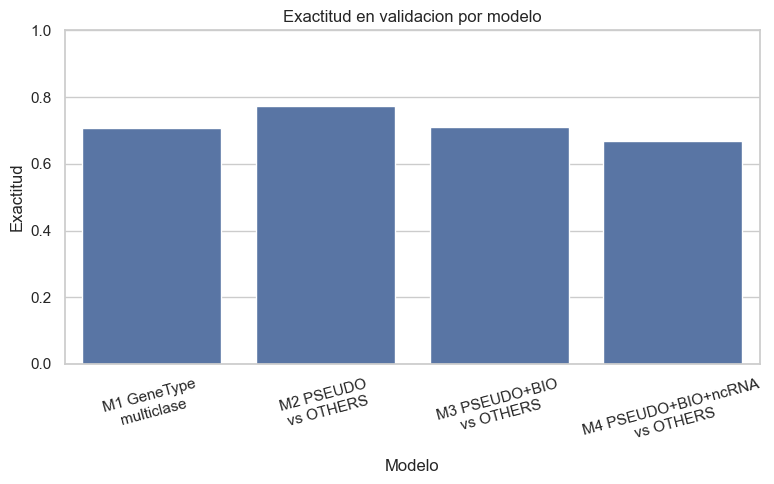

M1 GeneType
multiclase: 0.7070
M2 PSEUDO
vs OTHERS: 0.7719
M3 PSEUDO+BIO
vs OTHERS: 0.7090
M4 PSEUDO+BIO+ncRNA
vs OTHERS: 0.6675


In [59]:
model_names = [
    "M1 GeneType\nmulticlase",
    "M2 PSEUDO\nvs OTHERS",
    "M3 PSEUDO+BIO\nvs OTHERS",
    "M4 PSEUDO+BIO+ncRNA\nvs OTHERS"
]

val_accuracies = [acc_1, acc_2, acc_3, acc_4]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=val_accuracies)
plt.ylim(0.0, 1.0)
plt.title("Exactitud en validacion por modelo")
plt.ylabel("Exactitud")
plt.xlabel("Modelo")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

for name, acc in zip(model_names, val_accuracies):
    print(f"{name}: {acc:.4f}")


## Guardado de modelos entrenados

Se guardan los cuatro modelos entrenados en archivos `.pkl` para poder cargarlos
y usarlos posteriormente sin necesidad de volver a entrenar.


In [60]:
joblib.dump(model_1, "model_1_multiclass.pkl")
joblib.dump(model_2, "model_2_pseudo_vs_others.pkl")
joblib.dump(model_3, "model_3_pseudo_bioregion_vs_others.pkl")
joblib.dump(model_4, "model_4_pseudo_bioregion_ncrna_vs_others.pkl")

print("Modelos guardados correctamente en archivos .pkl")

Modelos guardados correctamente en archivos .pkl


## Funciones de prediccion para nuevas secuencias

A continuacion se definen funciones que cargan los modelos desde disco y predicen
el tipo de gen para una nueva secuencia de ADN. Tambien se muestra la distribucion
de probabilidades por clase, lo que sirve como medida de confianza.


In [61]:
def predict_multiclass(sequence, model_path="model_1_multiclass.pkl"):
    """
    Predice el tipo de gen original (GeneType completo) usando el modelo multiclase.
    """
    model = joblib.load(model_path)
    pred = model.predict([sequence])[0]
    probs = model.predict_proba([sequence])[0]
    print("\nModelo 1 - Clasificacion multiclase")
    print("Tipo de gen predicho:", pred)
    print("Probabilidades por clase:")
    for cls, p in zip(model.classes_, probs):
        print(f"  {cls}: {p:.4f}")
    return pred


def predict_pseudo_vs_others(sequence, model_path="model_2_pseudo_vs_others.pkl"):
    """
    Predice PSEUDO vs OTHERS usando el modelo binario 2.
    """
    model = joblib.load(model_path)
    pred = model.predict([sequence])[0]
    probs = model.predict_proba([sequence])[0]
    print("\nModelo 2 - Binario: PSEUDO vs OTHERS")
    print("Etiqueta predicha:", pred)
    print("Probabilidades:")
    for cls, p in zip(model.classes_, probs):
        print(f"  {cls}: {p:.4f}")
    return pred


def predict_pseudo_bioregion_vs_others(sequence, model_path="model_3_pseudo_bioregion_vs_others.pkl"):
    """
    Predice PSEUDO o BIOLOGICAL_REGION vs OTHERS usando el modelo 3.
    """
    model = joblib.load(model_path)
    pred = model.predict([sequence])[0]
    probs = model.predict_proba([sequence])[0]
    print("\nModelo 3 - Binario: PSEUDO, BIOLOGICAL_REGION vs OTHERS")
    print("Etiqueta predicha:", pred)
    print("Probabilidades:")
    for cls, p in zip(model.classes_, probs):
        print(f"  {cls}: {p:.4f}")
    return pred


def predict_pseudo_bioregion_ncrna_vs_others(sequence, model_path="model_4_pseudo_bioregion_ncrna_vs_others.pkl"):
    """
    Predice PSEUDO, BIOLOGICAL_REGION, ncRNA vs OTHERS usando el modelo 4.
    """
    model = joblib.load(model_path)
    pred = model.predict([sequence])[0]
    probs = model.predict_proba([sequence])[0]
    print("\nModelo 4 - PSEUDO, BIOLOGICAL_REGION, ncRNA vs OTHERS")
    print("Etiqueta predicha:", pred)
    print("Probabilidades:")
    for cls, p in zip(model.classes_, probs):
        print(f"  {cls}: {p:.4f}")
    return pred


In [70]:
def predict_gene_type(model, sequence):
    """
    Funcion generica que recibe un modelo ya entrenado y una secuencia de ADN,
    y muestra el tipo de gen predicho junto con las probabilidades por clase.
    """
    # Verificar que la secuencia sea una cadena no vacia
    if not isinstance(sequence, str) or len(sequence.strip()) == 0:
        print("Entrada invalida: se requiere una cadena de texto con nucleotidos.")
        return

    # Prediccion de clase
    prediction = model.predict([sequence])[0]

    # Probabilidades de cada clase
    probabilities = model.predict_proba([sequence])[0]
    prob_dict = dict(zip(model.classes_, probabilities))

    # Mostrar resultados
    print("Secuencia de ADN de entrada (truncada si es muy larga):")
    print(sequence[:100] + "..." if len(sequence) > 100 else sequence)

    print("\nTipo de gen predicho:", prediction)
    print("\nProbabilidades por clase:")
    for cls, prob in prob_dict.items():
        print(f"  {cls}: {prob:.4f}")

    return prediction


In [ ]:
# Ejemplo de secuencia (puede venir del test o de otra fuente)
example_sequence = "<AATGCAGAAGCACAGCTAAAATTTGAATTTCAGATAAACAAATTTTTCTTAGAATAAGTATGTCTCCATGCAACATTTGGGACATACTTATGCTAAAATATTATTTGTGTTTCATCTGAAATTCAAATTCAACTGGACATCCTGTATTTT>"

print("Prediccion con modelo multiclase (model_1):")
_ = predict_gene_type(model_1, example_sequence)  #  usando el modelo 1
print("Prediccion con modelo multiclase (model_2):")
_ = predict_gene_type(model_2, example_sequence)  # por ejemplo usando el modelo 2
print("Prediccion con modelo multiclase (model_3):")
_ = predict_gene_type(model_3, example_sequence)  # por ejemplo usando el modelo 3
print("Prediccion con modelo multiclase (model_4):")
_ = predict_gene_type(model_4, example_sequence)  # por ejemplo usando el modelo 4


Prediccion con modelo multiclase (model_1):
Secuencia de ADN de entrada (truncada si es muy larga):
<AATGCAGAAGCACAGCTAAAATTTGAATTTCAGATAAACAAATTTTTCTTAGAATAAGTATGTCTCCATGCAACATTTGGGACATACTTATGCTAAAAT...

Tipo de gen predicho: PSEUDO

Probabilidades por clase:
  BIOLOGICAL_REGION: 0.2726
  OTHER: 0.0081
  PROTEIN_CODING: 0.0049
  PSEUDO: 0.5326
  ncRNA: 0.1146
  rRNA: 0.0001
  scRNA: 0.0000
  snRNA: 0.0276
  snoRNA: 0.0390
  tRNA: 0.0004
Prediccion con modelo multiclase (model_2):
Secuencia de ADN de entrada (truncada si es muy larga):
<AATGCAGAAGCACAGCTAAAATTTGAATTTCAGATAAACAAATTTTTCTTAGAATAAGTATGTCTCCATGCAACATTTGGGACATACTTATGCTAAAAT...

Tipo de gen predicho: PSEUDO

Probabilidades por clase:
  OTHERS: 0.4477
  PSEUDO: 0.5523
Prediccion con modelo multiclase (model_3):
Secuencia de ADN de entrada (truncada si es muy larga):
<AATGCAGAAGCACAGCTAAAATTTGAATTTCAGATAAACAAATTTTTCTTAGAATAAGTATGTCTCCATGCAACATTTGGGACATACTTATGCTAAAAT...

Tipo de gen predicho: PSEUDO

Probabilidades por clase:
  

## Conclusion

En este proyecto se construyo un pipeline completo para predecir tipos de genes a partir
de secuencias de ADN, utilizando un dataset real de genes humanos. El flujo de trabajo incluyo:

- Carga y limpieza basica de los datos.
- Exploracion de la distribucion de `GeneType` y de las longitudes de secuencia.
- Definicion de varias etiquetas alternativas (multiclase y binarias).
- Representacion de las secuencias mediante TF-IDF de 3-gramas de caracteres, alineado con la idea biologica de codon.
- Entrenamiento de modelos de regresion logistica y evaluacion en un conjunto de validacion.
- Comparacion de modelos usando accuracy y matrices de confusion.
- Implementacion de funciones de prediccion y guardado de los modelos entrenados.

Los resultados muestran que incluso un modelo clasico como la regresion logistica, combinado
con una representacion adecuada basada en codones, es capaz de capturar patrones en las
secuencias de ADN y distinguir entre distintos tipos de genes con niveles de accuracy en el
rango de 0.67 a 0.77 segun la definicion de las clases.

Como trabajo futuro se propone:

- Explorar modelos de aprendizaje profundo (CNN, RNN, Transformers) que aprendan directamente
  de secuencias largas.
- Probar representaciones mas ricas basadas en k-mers y embeddings.
- Ampliar el conjunto de datos y balancear mejor las clases.
- Integrar metadatos biologicos adicionales para mejorar la calidad de las predicciones.

Este proyecto conecta el proceso de secuenciacion genetica con tecnicas de inteligencia
artificial, demostrando como un estudiante de Informatica puede aplicar herramientas de
aprendizaje automatico para apoyar problemas reales de bioinformatica.
